In [2]:
import pandas as pd
covid = pd.read_csv(r"C:\Users\htete\Downloads\Project2\covid_wide.csv")
sales = pd.read_csv(r"C:\Users\htete\Downloads\Project2\sales_wide.csv")
study = pd.read_csv(r"C:\Users\htete\Downloads\Project2\study_wide.csv")
covid.head(), sales.head(), study.head()


(   Country  2020-01  2020-02  2020-03  2020-04  2020-05
 0      USA        1       15     1000    30000   100000
 1    Italy        0        3      200    25000    80000
 2    Spain        0        1      150    20000    70000
 3   Canada        0        2      100    12000    40000
 4  Germany        0        2      180    22000    60000,
      Store  Jan_Sales  Feb_Sales  Mar_Sales  Apr_Sales
 0  Store A       1200       1500       1100       1700
 1  Store B        900       1000        950       1200
 2  Store C       2000       2100       1950       2500
 3  Store D       1800       1600       1700       2000,
   Student  Week1  Week2  Week3  Week4
 0   Alice      5      6      8      7
 1     Ben      3      4      5      4
 2   Clara      6      5      7      8
 3  Daniel      2      3      4      5
 4     Eva      7      6      8      9)

# IS 362 — Project 2: Tidying Wide Datasets and Analysis

Author: <Htet Thet>  
Date: <10/14/2025>  

**Assignment summary:** For three "wide" datasets I create CSVs, tidy them with pandas, perform the requested analysis, and document my cleaning steps and conclusions. Datasets used: `covid_wide.csv`, `sales_wide.csv`, `study_wide.csv`. (See Project 2 instructions for deliverables.) :contentReference[oaicite:1]{index=1}


In [3]:
# Imports and display options
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_columns = 60
pd.options.display.width = 120


Run the imports below. I will load CSVs from the working directory.

In [5]:
# Adjust paths if needed
covid = pd.read_csv(r"C:\Users\htete\Downloads\Project2\covid_wide.csv")
sales = pd.read_csv(r"C:\Users\htete\Downloads\Project2\sales_wide.csv")
study = pd.read_csv(r"C:\Users\htete\Downloads\Project2\study_wide.csv")

# Quick peek
print("COVID (wide) shape:", covid.shape)
display(covid.head())
print("SALES (wide) shape:", sales.shape)
display(sales.head())
print("STUDY (wide) shape:", study.shape)
display(study.head())


COVID (wide) shape: (5, 6)


,Country,2020-01,2020-02,2020-03,2020-04,2020-05
0,USA,1,15,1000,30000,100000
1,Italy,0,3,200,25000,80000
2,Spain,0,1,150,20000,70000
3,Canada,0,2,100,12000,40000
4,Germany,0,2,180,22000,60000


SALES (wide) shape: (4, 5)


,Store,Jan_Sales,Feb_Sales,Mar_Sales,Apr_Sales
0,Store A,1200,1500,1100,1700
1,Store B,900,1000,950,1200
2,Store C,2000,2100,1950,2500
3,Store D,1800,1600,1700,2000


STUDY (wide) shape: (5, 5)


,Student,Week1,Week2,Week3,Week4
0,Alice,5,6,8,7
1,Ben,3,4,5,4
2,Clara,6,5,7,8
3,Daniel,2,3,4,5
4,Eva,7,6,8,9


This cell reads the three wide CSVs and displays the first rows so we can inspect structure and confirm they are 'wide'.

**COVID (wide):** The dataset lists countries in rows but columns are monthly counts (e.g. 2020-01, 2020-02...). The time variable is embedded in column names, so the data is wide and must be made long.

**Store sales (wide):** Each store is a row and each month (Jan_Sales, Feb_Sales, ...) is a column. Month is in the column name, making aggregation and time-series plotting difficult.

**Study hours (wide):** Each student is a row and columns are Week1..Week4. Week is stored in the column headers instead of a `Week` variable.


**Tidy step for COVID:** Use pandas `melt()` to convert the monthly columns to a single `YearMonth` column, then convert to datetime and rename the value column to `Cases`. Check for missing values and numeric types.


In [6]:
# TIDY: COVID
covid_long = covid.melt(id_vars=["Country"], var_name="YearMonth", value_name="Cases")
# If YearMonth strings like '2020-01' convert to datetime (if format is YYYY-MM)
try:
    covid_long['Date'] = pd.to_datetime(covid_long['YearMonth'], format='%Y-%m')
except:
    # fallback: try more general parse
    covid_long['Date'] = pd.to_datetime(covid_long['YearMonth'], errors='coerce')

# ensure Cases numeric
covid_long['Cases'] = pd.to_numeric(covid_long['Cases'], errors='coerce')

# reorder columns
covid_long = covid_long[['Country','Date','Cases','YearMonth']]

display(covid_long.head(10))
print("Missing counts per column:\n", covid_long.isna().sum())


,Country,Date,Cases,YearMonth
0,USA,2020-01-01,1,2020-01
1,Italy,2020-01-01,0,2020-01
2,Spain,2020-01-01,0,2020-01
3,Canada,2020-01-01,0,2020-01
4,Germany,2020-01-01,0,2020-01
5,USA,2020-02-01,15,2020-02
6,Italy,2020-02-01,3,2020-02
7,Spain,2020-02-01,1,2020-02
8,Canada,2020-02-01,2,2020-02
9,Germany,2020-02-01,2,2020-02


Missing counts per column:
 Country      0
Date         0
Cases        0
YearMonth    0
dtype: int64


Notes: I converted YearMonth to Date, forced Cases to numeric, and checked missing values. Any missing/NaN rows will be noted and handled below.


**COVID analysis:** Plot monthly cases per country (line plot). Brief interpretation follows the plot.


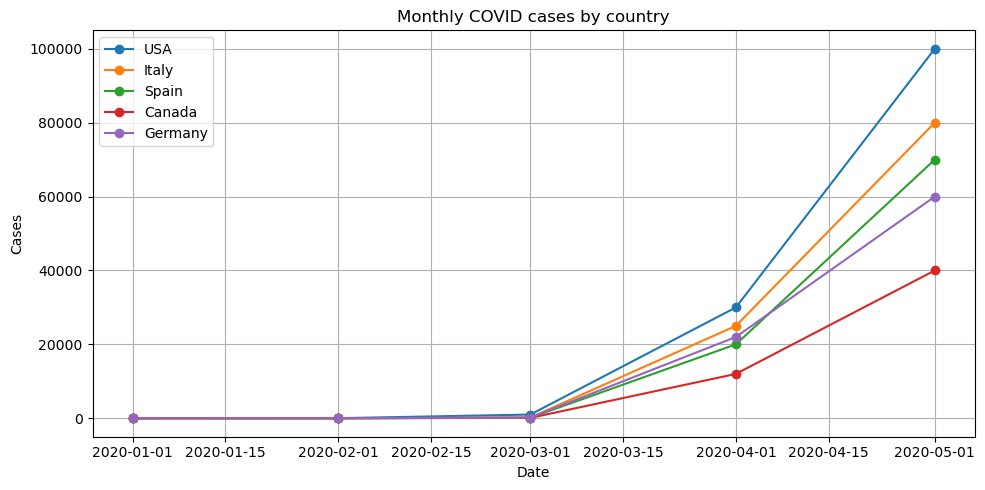

In [8]:
plt.figure(figsize=(10,5))
for country in covid_long['Country'].unique():
    dfc = covid_long[covid_long['Country']==country].sort_values('Date')
    plt.plot(dfc['Date'], dfc['Cases'], marker='o', label=country)
plt.xlabel("Date")
plt.ylabel("Cases")
plt.title("Monthly COVID cases by country")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Tidy step for Sales:** Use `melt()` with id_vars 'Store', convert Month column names to a datetime-friendly format if necessary, ensure Sales numeric.


In [9]:
# TIDY: Sales
sales_long = sales.melt(id_vars=["Store"], var_name="Month", value_name="Sales")
# If months are like 'Jan_Sales' remove suffix
sales_long['Month'] = sales_long['Month'].str.replace('_Sales','', regex=False)
# If you want proper dates, attach a year; here assume 2021
sales_long['Date'] = pd.to_datetime(sales_long['Month'] + "-2021", format='%b-%Y', errors='coerce')

sales_long['Sales'] = pd.to_numeric(sales_long['Sales'], errors='coerce')
sales_long = sales_long[['Store','Date','Month','Sales']]

display(sales_long)
print("Missing values:\n", sales_long.isna().sum())


,Store,Date,Month,Sales
0,Store A,2021-01-01,Jan,1200
1,Store B,2021-01-01,Jan,900
2,Store C,2021-01-01,Jan,2000
3,Store D,2021-01-01,Jan,1800
4,Store A,2021-02-01,Feb,1500
5,Store B,2021-02-01,Feb,1000
6,Store C,2021-02-01,Feb,2100
7,Store D,2021-02-01,Feb,1600
8,Store A,2021-03-01,Mar,1100
9,Store B,2021-03-01,Mar,950


Missing values:
 Store    0
Date     0
Month    0
Sales    0
dtype: int64


**Sales analysis:** Compute average monthly sales per store and plot a bar chart of average sales.


,Store,Avg_Sales,Total_Sales,Months
0,Store A,1375.0,5500,4
1,Store B,1012.5,4050,4
2,Store C,2137.5,8550,4
3,Store D,1775.0,7100,4


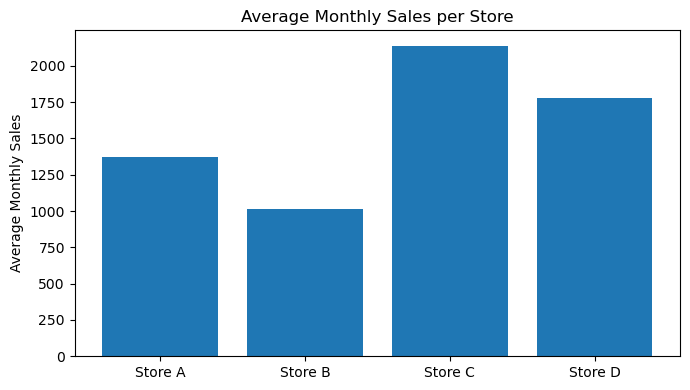

In [11]:
# summary
sales_summary = sales_long.groupby('Store')['Sales'].agg(['mean','sum','count']).reset_index()
sales_summary = sales_summary.rename(columns={'mean':'Avg_Sales','sum':'Total_Sales','count':'Months'})
display(sales_summary)

# bar plot of average sales
plt.figure(figsize=(7,4))
plt.bar(sales_summary['Store'], sales_summary['Avg_Sales'])
plt.ylabel("Average Monthly Sales")
plt.title("Average Monthly Sales per Store")
plt.tight_layout()
plt.show()


**Tidy step for Study Hours:** Melt Week1..Week4 into long form with columns Student, Week, Hours. Convert Week to numeric.


In [12]:
# TIDY: Study hours
study_long = study.melt(id_vars=["Student"], var_name="Week", value_name="Hours")
# convert Week -> numeric (extract number)
study_long['WeekNum'] = study_long['Week'].str.extract('Week(\d+)').astype(int)
study_long['Hours'] = pd.to_numeric(study_long['Hours'], errors='coerce')
study_long = study_long[['Student','WeekNum','Hours']].sort_values(['Student','WeekNum'])
display(study_long)
print("Missing values:\n", study_long.isna().sum())


,Student,WeekNum,Hours
0,Alice,1,5
5,Alice,2,6
10,Alice,3,8
15,Alice,4,7
1,Ben,1,3
6,Ben,2,4
11,Ben,3,5
16,Ben,4,4
2,Clara,1,6
7,Clara,2,5


Missing values:
 Student    0
WeekNum    0
Hours      0
dtype: int64


**Study analysis:** Plot each student's weekly hours and compute average hours per week across all students.


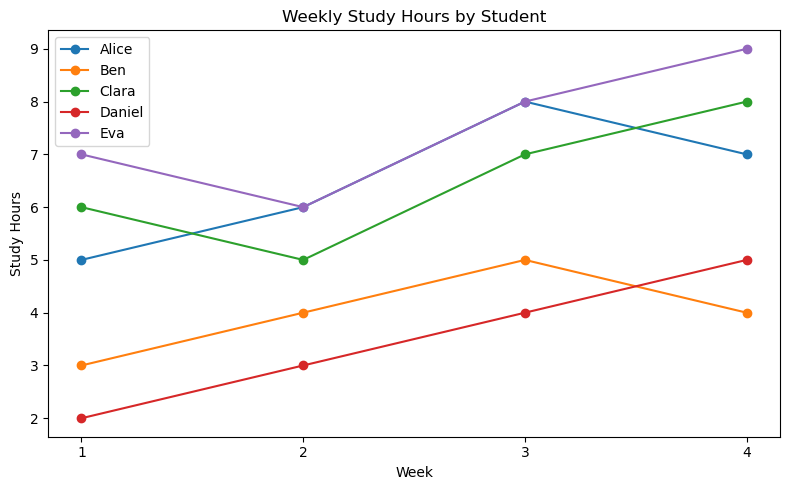

,WeekNum,Hours
0,1,4.6
1,2,4.8
2,3,6.4
3,4,6.6


In [13]:
# line plot per student
plt.figure(figsize=(8,5))
for student in study_long['Student'].unique():
    df = study_long[study_long['Student']==student]
    plt.plot(df['WeekNum'], df['Hours'], marker='o', label=student)
plt.xlabel("Week")
plt.ylabel("Study Hours")
plt.title("Weekly Study Hours by Student")
plt.xticks([1,2,3,4])
plt.legend()
plt.tight_layout()
plt.show()

# average hours per week
avg_by_week = study_long.groupby('WeekNum')['Hours'].mean().reset_index()
display(avg_by_week)


Save the tidy versions to CSV in the repo so graders can re-run the analyses.


In [14]:
covid_long.to_csv("covid_tidy.csv", index=False)
sales_long.to_csv("sales_tidy.csv", index=False)
study_long.to_csv("study_tidy.csv", index=False)
print("Saved tidy CSVs.")


Saved tidy CSVs.
